# Link Prediction using Graph Convolutional Network
In the previous project, I have explored the use of Graph Convolutional Network (GCN) for node classification in a biomedical Knowledge Graph (KG) [link](https://github.com/chauvu/chauvu.github.io/blob/main/Notebooks/graph_node_classification.ipynb). However, the node classification task is usually not of significant interest since we generally know what class a vertex belongs to in a graph. An active area of development is in knowledge graph completion, aka novel link prediction. For example, the task of drug repurposing requires predicting a link that has not been previously discovered between a *drug* node and a *disease* node, usually based on the connections between these two vertices with the rest of the graph.

These tasks are usually performed using reasoning models (e.g. from `(remdesivir, treats, viral disease)` and `(covid, is, viral disease)` can reason that (remdesivir, treats, covid)) or embedding models, which are low-dimensional representations of a node or relation. Similar to the idea of Word2Vec in NLP, for example in a translational embedding model [TransE](https://proceedings.neurips.cc/paper/2013/file/1cecc7a77928ca8133fa24680a88d2f9-Paper.pdf), `vector(remdesivir) + vector(treats)` is approximately `vector(covid)`. GCN has also been used in these embedding models as a relational-GCN [rGCN](https://arxiv.org/pdf/1703.06103.pdf), in which the node embeddings are propagated through the neighborhood using the message passing features of GCN. 

In this work, instead of the complex rGCN, I want to explore a very simple use of GCN: generate low-dimensional vectors for each node then use a *dot product* to calculate the score for each edge, subsequently using this score to perform binary classification whether an edge exists or not. I will be using the Deep Graph Library (DGL) to implement a GCN model.

Ideally, I would have performed this link prediction on Hetionet, the biomedical knowledge graph used in the previous [project](https://github.com/chauvu/chauvu.github.io/blob/main/Notebooks/graph_node_classification.ipynb). However, node classification is a smaller task at `O(E)`, whereas edge classification is significantly larger at `O(E^2)`. Hetionet has around 45k nodes, which has approximately 1 billion possible edges. Even if the edge doesn't exist, the size of the data is still extremely large, since the adjacency matrix is 1B x 1B. This would be a perfect candidate to perform sub-batching in GCN using subgraphs [link](https://arxiv.org/pdf/2002.07206.pdf). 

In this work, however, to simplify the training process, I will be using the Cora Citation Dataset, which is much smaller, to perform a proof-of-concept of the link prediction task with GCN.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor, nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import networkx as nx
import dgl
from dgl.nn.pytorch import GraphConv
from dgl.data import citation_graph as citegrh
from node2vec import Node2Vec
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from typing import Optional, Sequence
import warnings
warnings.filterwarnings("ignore")
import random
random.seed(100)

Using backend: pytorch


First, we will load the Cora Dataset from the DGL module. The dataset does split the nodes into training, validation and testing datasets; however, this is specifically for node classification tasks. Since we are interested in edge classification, we will have to use the original graph and perform train-test-validation-split on the edges instead.

In [2]:
G_dgl = citegrh.load_cora()
G_nx = G_dgl.graph
data = pd.DataFrame(G_nx.edges(), columns=['head', 'tail'])
entities = set(list(data['head'].unique()) + list(data['tail'].unique()))

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Train-test-validation split is performed on the edges. Care was taken to make sure that there are no unseen nodes from the testing and validation sets compared to the training set, so the validation and testing can be performed on the same training NetworkX/DGL graph (just with different sets of edges). Finally, we have approximately 2k edges in each test and valid set, and 8k edges in the training set.

In [3]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=100)
data_train, data_valid = train_test_split(data, test_size=0.2, random_state=101)
entities_train = set(list(data_train['head'].unique()) + list(data_train['tail'].unique()))

entities_test = set(list(data_test['head'].unique()) + list(data_test['tail'].unique()))
entities_test_diff = entities_test - entities_train
data_test_head_diff = data_test['head'].apply(lambda x: x in entities_test_diff)
data_test_tail_diff = data_test['tail'].apply(lambda x: x in entities_test_diff)
data_test_diff = data_test[data_test_head_diff | data_test_tail_diff]
data_test = data_test[~data_test_head_diff & ~data_test_tail_diff]
data_train = data_train.append(data_test_diff).drop_duplicates(ignore_index=True)

entities_valid = set(list(data_valid['head'].unique()) + list(data_valid['tail'].unique()))
entities_valid_diff = entities_valid - entities_train
data_valid_head_diff = data_valid['head'].apply(lambda x: x in entities_valid_diff)
data_valid_tail_diff = data_valid['tail'].apply(lambda x: x in entities_valid_diff)
data_valid_diff = data_valid[data_valid_head_diff | data_valid_tail_diff]
data_valid = data_valid[~data_valid_head_diff & ~data_valid_tail_diff]
data_train = data_train.append(data_valid_diff).drop_duplicates(ignore_index=True)

In [4]:
print('Train\t', len(data_train), 'edges')
print('Valid\t', len(data_valid), 'edges')
print('Test\t', len(data_test), 'edges')

Train	 8480 edges
Valid	 2076 edges
Test	 2103 edges


In [5]:
G_nx_train = nx.Graph() # undirected
G_nx_train.add_nodes_from(entities)
G_nx_train.add_edges_from(list(data_train[['head','tail']].to_records(index=False)))
G_nx_valid = nx.Graph() # undirected
G_nx_valid.add_nodes_from(entities)
G_nx_valid.add_edges_from(list(data_valid[['head','tail']].to_records(index=False)))
G_nx_test = nx.Graph() # undirected
G_nx_test.add_nodes_from(entities)
G_nx_test.add_edges_from(list(data_test[['head','tail']].to_records(index=False)))

Next, GCN requires a feature extraction step for each node. These features are considered the initial message that will be passed between connecting nodes to generate low-dimensional embeddings for each node. We have explored different feature engineering techniques in the node classification [project](https://github.com/chauvu/chauvu.github.io/blob/main/Notebooks/graph_node_classification.ipynb), including identity matrix, adjacency matrix and carefully hand-crafted features.

In this project, I will be using:
1. The already-extracted features for Cora (each feature is encoded by whether a specific word exists in the scientific publication)
2. The Node2Vec [algorithm](https://snap.stanford.edu/node2vec/), in which biased random walk is performed from a node, with specified probability of returning to the previous node or exploring unseen neighboring nodes.

### 1. Cora Existing Features

In [6]:
all_features = {}

In [7]:
cora_features = G_dgl.features
features_train = cora_features[torch.tensor(list(G_nx_train.nodes))]

all_features['cora'] = features_train

### 2. Node2Vec Features

In [8]:
already_generated = True
if not already_generated:
    random_walk_length = 100
    random_walk_num = 10
    random_walk_dimensions = 500

    model_n2v = Node2Vec(G_nx_train, dimensions=random_walk_dimensions, walk_length=random_walk_length, num_walks=random_walk_num).fit(window=10, min_count=1)
    features_train_np = model_n2v.wv.vectors
    features_train = torch.tensor(features_train_np)
    scaler = MinMaxScaler()
    features_train = torch.tensor(scaler.fit_transform(features_train)).float()
    n_features = features_train_np.shape[1]
    torch.save(features_train, 'features_cora_node2vec.pt')
else:
    features_train = torch.load('features_cora_node2vec.pt')
    
all_features['node2vec'] = features_train

# Preparation steps
### Focal Loss
Focal Loss is usually used for unbalanced data. In this case, the number of non-existing possible edges dominates, whereas only a few are actual edges between two nodes. Therefore, I will be using Focal Loss for my GCN training. The following focal loss function is taken from AdeelH's [github](https://github.com/AdeelH/pytorch-multi-class-focal-loss).

### Dot Product
Each node in the GCN is represented as a vector of fixed size `n_hidden` (number of hidden features). Our score function is calculated as the dot product between a pair of nodes to determine whether an edge exists between these two nodes. To perform this calculation on the entire set of nodes, I will perform `dot(x, x.t())`, where `x` is the matrix representation of size `(n_nodes, n_hidden)`. This dot product will yield a final matrix of size `n_nodes x n_nodes`.

This final matrix is symmetric across the diagonal axis, so we are only interested in the scores on the upper triangle or lower triangle. It is possible to use the `triu_indices` function, but this function includes the diagonal (whose scores should represent if there is an edge between a node with itself). Therefore, I will use this modified `triu_indices` function instead, taken from this [link](https://www.py4u.net/discuss/206235).

In [10]:
def upper_tri_indexing(A):
    m = A.shape[0]
    r,c = np.triu_indices(m,1)
    return A[r,c]

### Masks and Labels

In [11]:
def preparation(features_by):
    features_train = all_features[features_by]
    n_features = features_train.shape[1]
    
    n_nodes_train = features_train.shape[0]
    adj_train = nx.adjacency_matrix(G_nx_train, nodelist=G_nx_train.nodes()).toarray() # ordered
    labels_train = upper_tri_indexing(adj_train)
    labels_train = torch.tensor(labels_train).float()

    n_nodes_valid = features_train.shape[0]
    adj_valid = nx.adjacency_matrix(G_nx_valid, nodelist=G_nx_valid.nodes()).toarray() # ordered
    labels_valid = upper_tri_indexing(adj_valid)
    labels_valid = torch.tensor(labels_valid).float()
    labels_valid_save = labels_valid.clone()

    n_nodes_test = features_train.shape[0]
    adj_test = nx.adjacency_matrix(G_nx_test, nodelist=G_nx_test.nodes()).toarray() # ordered
    labels_test = upper_tri_indexing(adj_test)
    labels_test = torch.tensor(labels_test).float()
    labels_test_save = labels_test.clone()

    # TEST masks
    mask_test = labels_test.clone()
    labels_test_indices_nonedge = np.where(labels_test.detach().numpy()==0)[0]
    indices = torch.tensor(random.sample(range(labels_test_indices_nonedge.shape[0]), round(mask_test.sum().item())*5))
    labels_test_indices_nonedge_sample = labels_test_indices_nonedge[indices]
    mask_test[labels_test_indices_nonedge_sample] = 1

    # VALID masks
    mask_valid = labels_valid.clone()
    labels_valid_indices_nonedge = np.where(labels_valid.detach().numpy()==0)[0]
    indices = torch.tensor(random.sample(range(labels_valid_indices_nonedge.shape[0]), round(mask_valid.sum().item())*5))
    labels_valid_indices_nonedge_sample = labels_valid_indices_nonedge[indices]
    mask_valid[labels_valid_indices_nonedge_sample] = 1
    
    return features_train, n_features, labels_train, labels_valid, labels_valid_save, mask_valid, labels_test, labels_test_save, mask_test


In [12]:
G_dgl_train = dgl.from_networkx(G_nx_train)
G_dgl_train = dgl.add_self_loop(G_dgl_train)

# Graph Convolutional Network
For our GCN model, we will create two graph convolutional layers. Since we want to perform binary classification of an edge existence, we need to generate two separate features, one for edge=0 and one for edge=1. Focal loss is used with the weights as the probability whether a random edge exists or not (99% of the time an edge is non-existant).

In [13]:
class GCN(nn.Module):
    def __init__(self, n_features, n_hidden, activation):
        super(GCN, self).__init__()
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.activation = activation

        # layers
        self.layer1_1 = GraphConv(self.n_features, self.n_hidden, activation=self.activation)
        self.layer1_2 = GraphConv(self.n_hidden, self.n_hidden, activation=self.activation)

        self.layer2_1 = GraphConv(self.n_features, self.n_hidden, activation=self.activation)
        self.layer2_2 = GraphConv(self.n_hidden, self.n_hidden, activation=self.activation)

    def forward(self, G, x):
        x1 = self.layer1_1(G, x)
        x1 = nn.LayerNorm(x1.shape)(x1)
        x1 = self.layer1_2(G, x1)
        x1 = nn.LayerNorm(x1.shape)(x1)
        x1 = torch.mm(x1, x1.t())
        x1 = upper_tri_indexing(x1) # x1 = x1[torch.triu_indices(len(x1), len(x1)).unbind()]

        x2 = self.layer2_1(G, x)
        x2 = nn.LayerNorm(x2.shape)(x2)
        x2 = self.layer2_2(G, x2)
        x2 = nn.LayerNorm(x2.shape)(x2)
        x2 = torch.mm(x2, x2.t())
        x2 = upper_tri_indexing(x2) # x2 = x2[torch.triu_indices(len(x2), len(x2)).unbind()]

        x = torch.stack((x1,x2), dim=1)
        return x

In [14]:
def train(features_train, n_features, n_hidden=16, n_epochs=20, activation=None):
    G_dgl_train = dgl.from_networkx(G_nx_train)
    G_dgl_train = dgl.add_self_loop(G_dgl_train)
    G_dgl_valid = dgl.from_networkx(G_nx_valid)
    G_dgl_valid = dgl.add_self_loop(G_dgl_valid)
    G_dgl_test = dgl.from_networkx(G_nx_test)
    G_dgl_test = dgl.add_self_loop(G_dgl_test)


    model = GCN(n_features, n_hidden, activation)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
    alpha = torch.tensor([labels_train.sum() / len(labels_train), 1-labels_train.sum() / len(labels_train)])
    criterion = FocalLoss(gamma=20, alpha=alpha)

    # TRAIN and VALIDATION
    losses_train = []
    f1_valid, roc_valid, ap_valid = [], [], []
    for epoch in range(n_epochs):
        # training
        model.train()
        optimizer.zero_grad()
        output_train = model(G_dgl_train, features_train)

        loss = criterion(output_train, labels_train.long())
        loss.backward()
        optimizer.step()
        # print('Epoch {}, Loss {}'.format(epoch, loss.item()))
        losses_train.append(loss.item())

        # validation
        model.eval()
        output_valid = model(G_dgl_train, features_train)
        output_valid = output_valid[mask_valid==1]
        labels_valid = labels_valid_save.clone()
        labels_valid = labels_valid[mask_valid==1]
        o = output_valid.argmax(1).cpu().detach().numpy().astype(dtype='bool')
        l = labels_valid.cpu().detach().numpy().astype(dtype='bool')
        f1_valid.append(f1_score(o, l, average='macro'))
        roc_valid.append(roc_auc_score(o, l))
        ap_valid.append(average_precision_score(o, l))
        
    return model, losses_train, f1_valid, roc_valid, ap_valid

In [15]:
def test(model, G, features_train, labels_test, mask_test):
    labels_test = labels_test_save.clone()
    model.eval()
    with torch.no_grad():
        output_test = model(G, features_train)

        # only count test edges not in training set
        output_test = output_test[mask_test==1]
        labels_test = labels_test[mask_test==1]

        # calculate accuracy, sensitivity, specificity, roc
        o = output_test.argmax(1).cpu().detach().numpy().astype(dtype='bool')
        l = labels_test.cpu().detach().numpy().astype(dtype='bool')
        accuracy = (o==l).sum() / len(o) 
        sensitivity = (o & l).sum() / ((o & l).sum() + (~o & l).sum())
        specificity = (~o & ~l).sum() / ((~o & ~l).sum() + (o & ~l).sum())
        f1 = f1_score(o, l, average='macro')
        roc = roc_auc_score(o, l)
        ap = average_precision_score(o, l)
        
        test_results = pd.Series({'accuracy': np.round(accuracy,3), 
                          'sensitivity': np.round(sensitivity,3), 
                          'specificity': np.round(specificity,3), 
                          'F1': np.round(f1,3), 
                          'ROC': np.round(roc,3), 
                          'AP': np.round(ap,3),
                         })
        return test_results

### 1. Cora Features
It looks like at around 20 epochs, the validation metrics start decreasing. Therefore, we will train this for only 20 epochs. Most of the metrics fall around the range between 0.5 to 0.6, which shows that this simple algorithm performs only slightly better than randomly guessing whether an edge exists or not.

In [16]:
features_train, n_features, labels_train, labels_valid, labels_valid_save, mask_valid, labels_test, labels_test_save, mask_test = preparation('cora')
model, losses_train, f1_valid, roc_valid, ap_valid = train(features_train, n_features, n_epochs=50)

Text(0, 0.5, 'Training Loss')

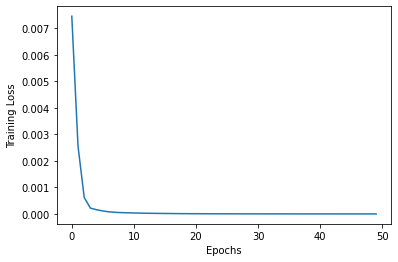

In [17]:
plt.plot(losses_train)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

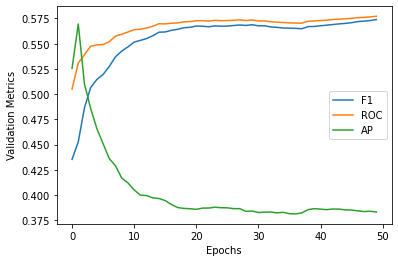

In [18]:
plt.plot(f1_valid)
plt.plot(roc_valid)
plt.plot(ap_valid)
plt.xlabel('Epochs')
plt.ylabel('Validation Metrics')
plt.legend(['F1', 'ROC', 'AP'])

In [19]:
features_train, n_features, labels_train, labels_valid, labels_valid_save, mask_valid, labels_test, labels_test_save, mask_test = preparation('cora')
model, losses_train, f1_valid, roc_valid, ap_valid = train(features_train, n_features, n_epochs=20)
test_results = test(model, G_dgl_train, features_train, labels_test, mask_test)
print(test_results)


accuracy       0.555
sensitivity    0.641
specificity    0.537
F1             0.496
ROC            0.549
AP             0.524
dtype: float64


### 2. Node2Vec
The evaluation metrics on the test set using node2vec are on the similar range with using the Cora Citation Features. However, looking at the F1, ROC and AP scores for the validation set through the epochs, it looks like these metrics are not stable using node2vec (using the Cora features the metrics do level out at later epochs). This demonstrates that random walk feature generation might not be very stable and might not capture innate features of the nodes in our graph.

Overall, evaluation metrics are also around 0.5-0.6, which is slightly better than random guessing. However, this is not good enough to make informed decision for knowledge graph completion or link prediction.

In [20]:
features_train, n_features, labels_train, labels_valid, labels_valid_save, mask_valid, labels_test, labels_test_save, mask_test = preparation('node2vec')
model, losses_train, f1_valid, roc_valid, ap_valid = train(features_train, n_features, n_epochs=50)

Text(0, 0.5, 'Training Loss')

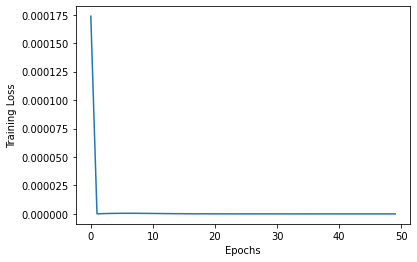

In [21]:
plt.plot(losses_train)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')

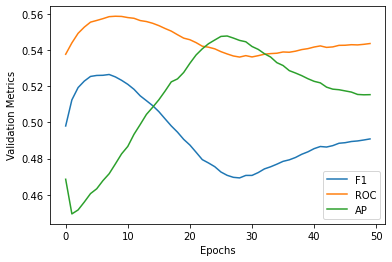

In [22]:
plt.plot(f1_valid)
plt.plot(roc_valid)
plt.plot(ap_valid)
plt.xlabel('Epochs')
plt.ylabel('Validation Metrics')
plt.legend(['F1', 'ROC', 'AP'])

In [23]:
features_train, n_features, labels_train, labels_valid, labels_valid_save, mask_valid, labels_test, labels_test_save, mask_test = preparation('cora')
model, losses_train, f1_valid, roc_valid, ap_valid = train(features_train, n_features)
test_results = test(model, G_dgl_train, features_train, labels_test, mask_test)
print(test_results)

accuracy       0.626
sensitivity    0.565
specificity    0.638
F1             0.538
ROC            0.559
AP             0.436
dtype: float64


# Conclusion
In this project, we constructed a 2-layer GCN to perform link prediction in a knowledge graph: GCN generates latent representations of each node, and for each pair of node, the score of whether an edge exists is the dot product between the vector representations of the two nodes. Our work demonstrates a proof-of-concept on a Cora Citation dataset and shows an accuracy of ~0.6 for predicting links.

Since our evaluation metrics are only slightly better than random guessing, this algorithm might not be robust enough to perform link predictions for downstream tasks such as drug repurposing. It is likely that this algorithm is too simplistic. Maybe embedding-based algorithms, such as translational models or reasoning models, are probably better to perform link predictions. Additionally, these algorithms can also represent specific types of links as low-dimensional vector representations, which can have more robust and versatile applications.